# 取り組み

ThinkpadX1-NanoのPCでもquickstart.pyを動かしてみる
+ [ ] Albino点変異の1%

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)
print(os.getcwd())

/mnt/d/Research/DAJIN2


In [2]:
%%bash
pip install -U pip
pip install -U -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pysam
    Found existing installation: pysam 0.19.1
    Uninstalling pysam-0.19.1:
      Successfully uninstalled pysam-0.19.1
  Attempting uninstall: plotly
    Found existing installation: plotly 5.10.0
    Uninstalling plotly-5.10.0:
      Success

# 実験

In [3]:
%%bash
pwd
rm -rf "DAJINResults/.tempdir"
find DAJINResults

/mnt/d/Research/DAJIN2
DAJINResults


In [4]:
%%bash
# Tyr 01%
time python misc/quickstart.py

processing test-pm-tyr...


Traceback (most recent call last):
  File "/mnt/d/Research/DAJIN2/misc/quickstart.py", line 170, in <module>
    clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 36, in add_labels
    scores_control = annotate_score(cssplits_control, mutation_score)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/annotate_score.py", line 9, in annotate_score
    if not mutation_score[i]:
IndexError: list index out of range

real	0m50.166s
user	0m38.961s
sys	0m5.745s


CalledProcessError: Command 'b'# Tyr 01%\ntime python misc/quickstart.py\n'' returned non-zero exit status 1.

### エラーが発生した

```text
Traceback (most recent call last):
  File "/mnt/c/Users/akihi/Documents/GitHub/DAJIN2/misc/quickstart.py", line 170, in <module>
    clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
  File "/mnt/c/Users/akihi/Documents/GitHub/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 36, in add_labels
    scores_control = annotate_score(cssplits_control, mutation_score)
  File "/mnt/c/Users/akihi/Documents/GitHub/DAJIN2/src/DAJIN2/core/clustering/annotate_score.py", line 9, in annotate_score
    if not mutation_score[i]:
IndexError: list index out of range
```
ということで、`clustering/annotate_score`のエラーである

In [5]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report
from src.DAJIN2.core.clustering import clustering

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)


##### # * Point mutation
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "examples/pm-tyr/barcode31.fq.gz",
    "examples/pm-tyr/barcode32.fq.gz",
    "examples/pm-tyr/design_tyr.fa",
    "test-pm-tyr",
    "mm10",
    True,
    14,
)

print(f"processing {NAME}...")

##########################################################
# Check inputs
##########################################################
preprocess.check_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.check_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.check_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.check_inputs.check_and_fetch_genome(GENOME)

##########################################################
# Format inputs
##########################################################
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing test-pm-tyr...


In [6]:
########################################################################
# Classify alleles
########################################################################

classif_sample = classification.classify_alleles(TEMPDIR, SAMPLE_NAME)

for classif in classif_sample:
    classif["SV"] = classification.detect_sv(classif["CSSPLIT"], threshold=50)

In [7]:
########################################################################
# Clustering
########################################################################

clust_sample = clustering.add_labels(classif_sample, TEMPDIR, CONTROL_NAME, FASTA_ALLELES, THREADS)
clust_sample = clustering.add_readnum(clust_sample)
clust_sample = clustering.add_percent(clust_sample)
clust_sample = clustering.update_labels(clust_sample)


IndexError: list index out of range

### ☝️ 確かにエラーが再現された

In [8]:
from __future__ import annotations
from itertools import groupby
from copy import deepcopy
from collections import defaultdict
from pathlib import Path
import midsv

from src.DAJIN2.core.preprocess.correct_knockin import extract_knockin_loci
from src.DAJIN2.core.clustering.preprocess import replace_both_ends_n, compress_insertion
from src.DAJIN2.core.clustering.make_score import make_score
from src.DAJIN2.core.clustering.annotate_score import annotate_score
from src.DAJIN2.core.clustering.reorder_labels import reorder_labels
from src.DAJIN2.core.clustering.return_labels import return_labels

In [9]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
for path_midsv in paths_midsv:
    midsv_control = midsv.read_jsonl(path_midsv)
    allele = path_midsv.stem.split("_")[-1]
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    cssplits_control_by_alleles[allele] = cssplits

In [10]:
knockin_alleles = extract_knockin_loci(TEMPDIR)
labels_all = []
max_label = 0
classif_sample.sort(key=lambda x: (x["ALLELE"], x["SV"]))
for (allele, _), group in groupby(classif_sample, key=lambda x: (x["ALLELE"], x["SV"])):
    print(allele)
    cssplits_control = cssplits_control_by_alleles[allele]
    cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
    cssplits_control = replace_both_ends_n(cssplits_control)
    cssplits_sample = replace_both_ends_n(cssplits_sample)
    cssplits_control = compress_insertion(cssplits_control)
    cssplits_sample = compress_insertion(cssplits_sample)
    mutation_score = make_score(cssplits_control, cssplits_sample, knockin_alleles[allele])
    scores_control = annotate_score(cssplits_control, mutation_score)
    scores_sample = annotate_score(cssplits_sample, mutation_score)
    labels = return_labels(scores_sample, scores_control)
    labels_reorder = reorder_labels(labels, start=max_label)
    max_label = max(labels_reorder)
    labels_all.extend(labels_reorder)
clust_sample = deepcopy(classif_sample)
for clust, label in zip(clust_sample, labels_all):
    clust["LABEL"] = label


albino


IndexError: list index out of range

### allele="albino"でエラーが起きている

In [11]:
allele="albino"

In [12]:
cssplits_control = cssplits_control_by_alleles[allele]
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in group]
cssplits_control = replace_both_ends_n(cssplits_control)
cssplits_sample = replace_both_ends_n(cssplits_sample)
cssplits_control = compress_insertion(cssplits_control)
cssplits_sample = compress_insertion(cssplits_sample)

In [13]:
from copy import deepcopy
cssplits = deepcopy(cssplits_control)

In [14]:
scores = []
for idx, cssplit in enumerate(cssplits):
    score = [0]
    for i in range(1, len(cssplit) - 1):
        if not mutation_score[i]:
            score.append(0)
            continue
        kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
        score.append(mutation_score[i].get(kmer, 0))
    scores.append(score + [0])


IndexError: list index out of range

In [15]:
print(idx)
print(len(cssplit))
print(len(mutation_score))
print(len(FASTA_ALLELES[allele]))

839
2932
2845
2845


### `839`番目のリード長が`2932`と、アルビノ配列よりも長くなっている

In [16]:
paths_midsv = list(Path(TEMPDIR, "midsv").glob(f"{CONTROL_NAME}_splice_*"))
cssplits_control_by_alleles = defaultdict(list)
print(paths_midsv)
for path_midsv in paths_midsv:
    if not path_midsv.stem.endswith(allele):
        continue
    midsv_control = midsv.read_jsonl(path_midsv)
    cssplits = [cs["CSSPLIT"].split(",") for cs in midsv_control]
    cssplits_control_by_alleles[allele] = cssplits

[PosixPath('DAJINResults/.tempdir/test-pm-tyr/midsv/barcode32_splice_control.jsonl'), PosixPath('DAJINResults/.tempdir/test-pm-tyr/midsv/barcode32_splice_albino.jsonl')]


In [17]:
midsv_control[idx].keys()

dict_keys(['QNAME', 'RNAME', 'CSSPLIT', 'QSCORE'])

In [18]:
len(midsv_control[idx]["CSSPLIT"].split(","))

2932

In [19]:
print(midsv_control[idx]["QNAME"])

de8715b1-7f61-4b2e-83c4-e949ab9aaf37


In [20]:
print(midsv_control[idx]["CSSPLIT"])

N,N,N,N,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,=A,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,=A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,=A,=G,=C,=T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,=T,=G,=T,=C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,=C,=A,=T,=T,=T,=G,=C,=A,=A,=A,=T,=T,=C,=C,=A,=A,=T,=T,=A,=T,=T,=A,=T,=T,=A,=A,=T,=T,=T

`de8715b1-7f61-4b2e-83c4-e949ab9aaf37`でエラーが起きている

```text
N,N,N,N,=T,=T,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=G,=A,=T,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,（略）=t,=t,=c,=a,=a,=g,=a,=t,=a,=a,=t,=c,=a,=a,=g,=g,=a,=a,=a,=a,=a,=t,=g,=a,=g,=a,=g,=g,=c,=a,=a,=c,=t,=a,=t,=t,=t,=t,=a,=g,=a,=c,=t,=g,=a,=t,=t,=a,=c,=t,=t,=t
```

midsvを更新したのに、まだエラーが出ている

In [26]:
%%bash
query="DAJINResults/.tempdir/test-pm-tyr/sam/barcode32_splice_albino.sam"
cat "$query" | grep -e "^@" -e "e949ab9aaf37" | samtools sort > tmp.bam
samtools index tmp.bam


IGVで可視化したところ、やはり中途半端に重複しているリードだった

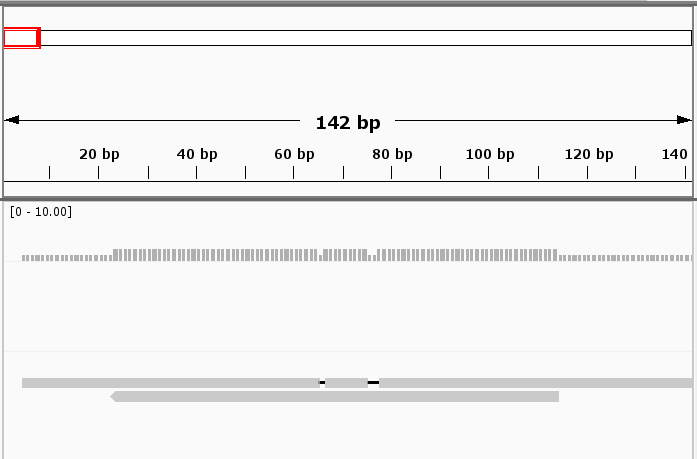

## MIDSVの更新
- 中途半端に重複しているリードのうち、短いものを除去する

# 結果


+ [x] Albino点変異の1%

無事に1%のアレルを補足できていることがわかった

# 次回の課題

+ [x] ~~点変異、欠失、ノックインのデザインで動くかを確認する~~
+ [x] ~~Clusteringのときの警告メッセージは無害なので消去する~~
+ [ ] right_loxpがいまいちな理由を考察する
    +  ~~[x] Ayabe-task1のpreprocessにおいて、329と1280の補正がされていない理由を検討する~~
+ [x] ~~distanceの閾値を下げた状態で、1%点変異が検出できるか~~
+ [ ] Insertionのなかにある変異を同定する手法を考案する
+ [ ] `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする
+ [ ] cis変異の両端が欠失している場合に、Nで置き換えるとtransとなってしまうのをどうするか（`replace_n`）
+ [ ] 短いリードの扱いをどうするべきか